# Part (a) – K-Means Clustering **from Scratch**

This notebook implements the K-Means clustering algorithm **without** using `sklearn.cluster.KMeans`.

Steps:
1. Load a tabular dataset (default: Iris).
2. Select numeric features and standardize them.
3. Implement K-Means manually using NumPy.
4. Visualize the clusters in 2D using PCA.
5. Evaluate clustering quality using silhouette score.


Assignment Done By :- Dev Mulchandani

In [1]:
# @title Load dataset (upload / URL / Kaggle)
import pandas as pd
import zipfile
from pathlib import Path

try:
    from google.colab import files  # type: ignore
    IN_COLAB = True
except Exception:
    IN_COLAB = False

DEFAULT_URL = "https://raw.githubusercontent.com/mwaskom/seaborn-data/master/iris.csv"  # You can change this to another CSV URL

print("How do you want to load the dataset?")
print("1 = upload CSV file manually")
print("2 = download from URL (uses DEFAULT_URL above)")
print("3 = download from Kaggle (you must provide kaggle.json & dataset name)")
choice = input("Enter 1, 2, or 3: ").strip()

if choice == "1":
    if not IN_COLAB:
        raise RuntimeError("Manual upload only works in Google Colab.")
    uploaded = files.upload()
    fname = list(uploaded.keys())[0]
    df = pd.read_csv(fname)
    print("Loaded:", fname, "shape:", df.shape)
elif choice == "2":
    if not DEFAULT_URL:
        raise ValueError("DEFAULT_URL is empty. Please set it to a valid CSV URL or choose another option.")
    df = pd.read_csv(DEFAULT_URL)
    print("Loaded from URL. Shape:", df.shape)
elif choice == "3":
    import os, subprocess

    if IN_COLAB:
        from google.colab import files  # type: ignore
        print("Please upload your kaggle.json file (from your Kaggle account).")
        uploaded = files.upload()
        kaggle_path = Path("~/.kaggle").expanduser()
        kaggle_path.mkdir(parents=True, exist_ok=True)
        for fn in uploaded:
            Path(fn).replace(kaggle_path / "kaggle.json")
        os.chmod(kaggle_path / "kaggle.json", 0o600)

    # Install kaggle CLI
    import sys
    !pip -q install kaggle

    DATASET_SLUG = input("Enter Kaggle dataset slug (e.g. 'uciml/iris'): ").strip()

    # Download entire dataset (may contain multiple files)
    !kaggle datasets download -d $DATASET_SLUG -p kaggle_data

    # Unzip everything
    kaggle_dir = Path("kaggle_data")
    kaggle_dir.mkdir(exist_ok=True)
    for zpath in kaggle_dir.glob("*.zip"):
        with zipfile.ZipFile(zpath, "r") as zf:
            zf.extractall(kaggle_dir)

    csv_files = list(kaggle_dir.rglob("*.csv"))
    if not csv_files:
        raise FileNotFoundError("No CSV files found in Kaggle dataset; please inspect kaggle_data/ manually.")
    csv_path = csv_files[0]
    print("Using CSV:", csv_path)
    df = pd.read_csv(csv_path)
    print("Loaded from Kaggle. Shape:", df.shape)
else:
    raise ValueError("Invalid choice. Please run this cell again.")

df.head()


How do you want to load the dataset?
1 = upload CSV file manually
2 = download from URL (uses DEFAULT_URL above)
3 = download from Kaggle (you must provide kaggle.json & dataset name)
Enter 1, 2, or 3: 2
Loaded from URL. Shape: (150, 5)


,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [2]:
# @title Basic preprocessing
import numpy as np
from sklearn.preprocessing import StandardScaler

# Use all numeric columns for clustering
X = df.select_dtypes(include=["float64", "int64"]).values
print("Feature matrix shape:", X.shape)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


Feature matrix shape: (150, 4)


In [3]:
# @title K-Means implementation from scratch
import numpy as np

def initialize_centroids(X, k, random_state=42):
    rng = np.random.default_rng(random_state)
    indices = rng.choice(len(X), size=k, replace=False)
    return X[indices]

def assign_clusters(X, centroids):
    distances = np.linalg.norm(X[:, None, :] - centroids[None, :, :], axis=2)
    return np.argmin(distances, axis=1)

def update_centroids(X, labels, k):
    new_centroids = []
    for i in range(k):
        cluster_points = X[labels == i]
        if len(cluster_points) == 0:
            new_centroids.append(X[np.random.randint(0, len(X))])
        else:
            new_centroids.append(cluster_points.mean(axis=0))
    return np.vstack(new_centroids)

def kmeans(X, k, max_iters=100, tol=1e-4):
    centroids = initialize_centroids(X, k)
    for it in range(max_iters):
        labels = assign_clusters(X, centroids)
        new_centroids = update_centroids(X, labels, k)
        shift = np.linalg.norm(new_centroids - centroids)
        centroids = new_centroids
        print(f"Iteration {it+1}, centroid shift = {shift:.6f}")
        if shift < tol:
            print("Converged.")
            break
    return labels, centroids

k = 3  # you can change this
labels, centroids = kmeans(X_scaled, k=k)


Iteration 1, centroid shift = 1.783868
Iteration 2, centroid shift = 0.217498
Iteration 3, centroid shift = 0.055600
Iteration 4, centroid shift = 0.059823
Iteration 5, centroid shift = 0.000000
Converged.


In [4]:
# @title Evaluate clustering quality
from sklearn.metrics import silhouette_score

score = silhouette_score(X_scaled, labels)
print(f"Silhouette score: {score:.3f}")


Silhouette score: 0.457


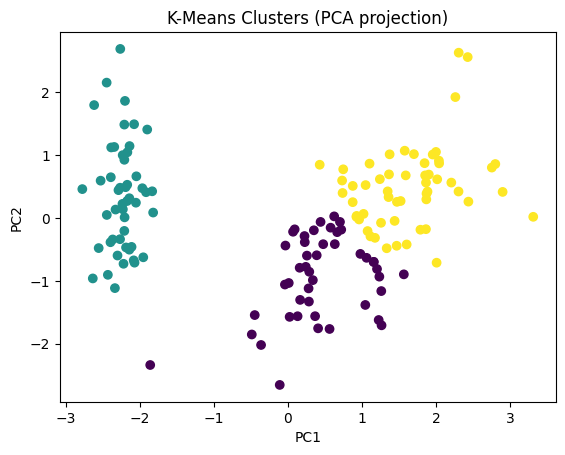

In [5]:
# @title Visualize clusters (first 2 principal components)
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_scaled)

plt.figure()
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels)
plt.title("K-Means Clusters (PCA projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()
